# Imports

In [ ]:
# basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE
# mlflow
import mlflow
# great expectations
import great_expectations as gx
# nannyml
import nannyml as nml
# termcolor
from termcolor import colored
from nannyml.chunk import SizeBasedChunker
from sklearn.impute import SimpleImputer



# MLFlow Experiment

FIRST: 
1. open ***mlflow ui*** via terminal

In [2]:
# Create a new experiment
experiment_name = "MLOps Project"

# create new experiment if not existing
try:
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
# if experiment already exists, set experiment
except:
    mlflow.set_experiment(experiment_name)

In [3]:
# get experiment id
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# Load Data

In [4]:
dataframe = pd.read_csv('Data/smoke_detection.csv', index_col=[0])

# Split Data

To simulate multiple datasets we're going to order the dataset bei the *UTC* column and split it into 3 equal parts

In [5]:
def split_dataframe(dataframe: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # order dataframe by month
    dataframe = dataframe.sort_values(by='UTC').reset_index(drop=True)
    
    # split dataframe into 3 equal sized datasets
    dataframe_1 = dataframe.iloc[:int(len(dataframe)/3)]
    dataframe_2 = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    dataframe_3 = dataframe.iloc[int(len(dataframe)/3)*2:]
    
    return dataframe_1, dataframe_2, dataframe_3

In [6]:
# pandas dataframes
df1, df2, df3 = split_dataframe(dataframe)

In [7]:
for i in [df1, df2, df3]:
    print(i.shape)

(20876, 15)
(20876, 15)
(20878, 15)


# EDA

In [8]:
print(f'Rows: {df1.shape[0]}\nColumns: {df1.shape[1]}')

Rows: 20876
Columns: 15


In [9]:
# first look at the data
df1.sample(5)

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
4463,1654716650,50.260,23.67,21523,632,12691,18906,936.882,0.71,0.74,4.90,0.764,0.017,4463,0
14001,1654741588,-4.456,56.61,319,400,13104,19941,939.427,0.35,0.36,2.39,0.372,0.008,8257,1
16876,1654744463,7.785,48.37,1005,638,12804,19483,939.057,2.53,2.62,17.39,2.711,0.061,11132,1
885,1654713072,29.210,40.63,83,400,12784,20664,937.550,2.14,2.22,14.73,2.297,0.052,885,0
16603,1654744190,4.753,53.38,1002,662,12793,19475,939.047,2.92,3.03,20.06,3.129,0.071,10859,1


In [10]:
# descriptive statistics, data types and missing values
def dataset_infos(dataframe: pd.DataFrame = dataframe) -> pd.DataFrame:
    # descriptive statistics
    descriptives = dataframe.describe(include='all').T

    # data types column
    descriptives.insert(loc=0, column='dtype', value=dataframe.dtypes)
    
    # missing values
    missing = pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['nulls','empty strings'], axis=1)
    
    return pd.merge(descriptives, missing, left_index=True, right_index=True)

dataset_infos(df1)

,dtype,count,mean,std,min,25%,50%,75%,max,nulls,empty strings
UTC,int64,20876.0,1.654734e+09,12154.941397,1.654712e+09,1.654717e+09,1.654738e+09,1.654743e+09,1.654748e+09,0,0
Temperature[C],float64,20876.0,1.445650e+01,16.777181,-9.276000e+00,-4.094000e+00,1.693150e+01,2.637800e+01,5.993000e+01,0,0
Humidity[%],float64,20876.0,4.826455e+01,9.486005,1.074000e+01,4.700000e+01,5.015000e+01,5.336000e+01,7.520000e+01,0,0
TVOC[ppb],int64,20876.0,2.311279e+03,9539.882264,0.000000e+00,6.700000e+01,2.220000e+02,1.027000e+03,6.000000e+04,0,0
eCO2[ppm],int64,20876.0,6.927393e+02,1925.904927,4.000000e+02,4.000000e+02,4.000000e+02,5.090000e+02,3.918500e+04,0,0
Raw H2,int64,20876.0,1.295284e+04,318.702438,1.066800e+04,1.279400e+04,1.286800e+04,1.315100e+04,1.380300e+04,0,0
Raw Ethanol,int64,20876.0,1.990383e+04,683.249922,1.531700e+04,1.948400e+04,1.997600e+04,2.019125e+04,2.141000e+04,0,0
Pressure[hPa],float64,20876.0,9.387859e+02,1.004823,9.366240e+02,9.375470e+02,9.390970e+02,9.396340e+02,9.398610e+02,0,0
PM1.0,float64,20876.0,1.130871e+02,950.738240,0.000000e+00,7.600000e-01,1.820000e+00,2.160000e+00,1.334669e+04,0,0
PM2.5,float64,20876.0,1.936200e+02,1864.035040,0.000000e+00,8.000000e-01,1.890000e+00,2.240000e+00,4.126298e+04,0,0


In [11]:
# duplicate rows
print(f'Duplicated Rows: {df1.duplicated().sum()}')

Duplicated Rows: 0


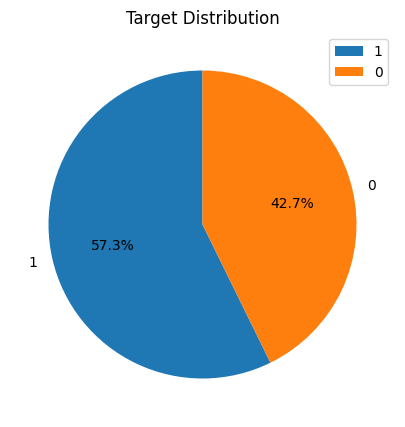

In [12]:
# plot target distribution (pie chart)
def plot_target_distribution(dataframe: pd.DataFrame = dataframe, target='Fire Alarm'):
    plt.figure(figsize=(10,5))
    plt.pie(dataframe[target].value_counts(), labels=dataframe[target].value_counts().index, autopct='%1.1f%%', startangle=90)
    plt.title('Target Distribution')
    plt.legend()
    plt.show()

plot_target_distribution(df1)

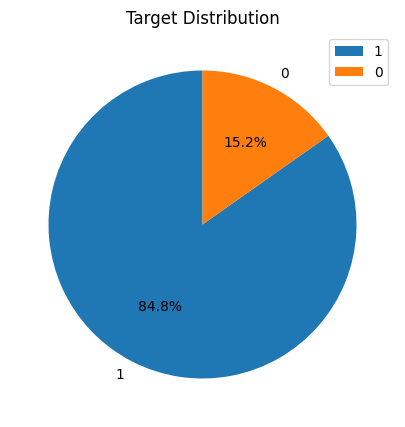

In [13]:
plot_target_distribution(df2)

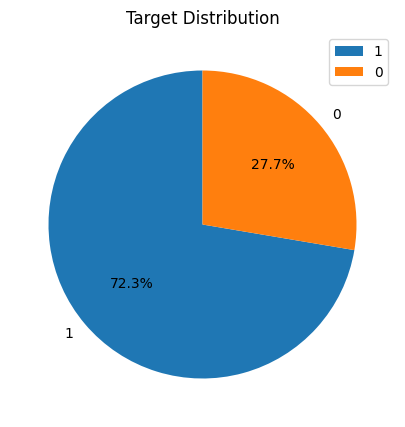

In [14]:
plot_target_distribution(df3)

# Preprocessing

In [15]:
x, y = df1.drop(columns=['Fire Alarm']), df1['Fire Alarm']

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y,random_state=420)

In [17]:
def preprocessing(x: pd.DataFrame, y: pd.Series = None, reset: bool = False) -> pd.DataFrame:
  '''
  Preprocessing function
  Input: dataframe
  Output: transformed data
  '''

  run_name = "Preprocessing Pipeline"

  # preprocessing pipeline
  pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    # ('power_transformer', PowerTransformer())
    ])
    
  # Search for preprocessing run
  run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{run_name}'")
  # get run id
  run_id = run.iloc[0].run_id if not run.empty else None

  # if preprocessing-run does not exist or retrain
  if reset or run.empty:
    # Delete the last run if it exists
    if run_id is not None:
        mlflow.delete_run(run_id)
        print('Last run deleted')
    # drop sample count (CNT) column
    x = x.drop(columns=['CNT'])
    # convert UTC column to datetime
    x['Timestamp'] = pd.to_datetime(x['UTC'], unit='s')
    # drop UTC column
    x = x.drop(columns=['UTC'])
    # create new columns
    x['Hour'], x['WeekDay'] = x['Timestamp'].dt.hour, x['Timestamp'].dt.dayofweek
    # drop timestamp column
    x = x.drop(columns=['Timestamp'])
    # fit & transform pipeline
    data_preprocessed = pipeline.fit_transform(x)
    # SMOTE
    if y is not None:
      # smote
      smote = SMOTE(random_state=420)
      # fit smote
      x_smote, y_smote = smote.fit_resample(data_preprocessed, y)
    # print fit and transform message
    print('Preprocessing Pipeline: fit and transform')
    # start run
    with mlflow.start_run(run_name=run_name) as run:
      # log pipeline
      mlflow.sklearn.log_model(pipeline, 'PreprocessingPipeline')
      # end run
      mlflow.end_run()

    return x_smote, y_smote
    
  # if preprocessing-run exists
  else:
    # load pipeline
    pipeline = mlflow.sklearn.load_model(f'runs:/{run_id}/PreprocessingPipeline')
    # drop sample count (CNT) column
    x = x.drop(columns=['CNT'])
    # convert UTC column to datetime
    x['Timestamp'] = pd.to_datetime(x['UTC'], unit='s')
    # drop UTC column
    x = x.drop(columns=['UTC'])
    # create new columns
    x['Hour'], x['WeekDay'] = x['Timestamp'].dt.hour, x['Timestamp'].dt.dayofweek
    # drop timestamp column
    x = x.drop(columns=['Timestamp'])
    # transform data
    data_preprocessed = pipeline.transform(x)
    # print transform message
    print('Preprocessing Pipeline: transform')
    # only return x (no smote on new data)
    return data_preprocessed

In [18]:
# preprocess training data
xtrain_prepro, ytrain_prepro = preprocessing(xtrain, ytrain, reset=True)


Last run deleted
Preprocessing Pipeline: fit and transform


2023/06/11 17:51:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [19]:
# preprocess test data
xtest_prepro = preprocessing(xtest)

Preprocessing Pipeline: transform


# Modelling

## Training Multiple Classifiers

In [20]:
# fit prediction model on train dataset
def classifier_comparison(
    xtrain: pd.DataFrame = xtrain_prepro,
    ytrain: pd.DataFrame = ytrain_prepro,
    xtest: pd.DataFrame = xtest_prepro,
    ytest: pd.DataFrame = ytest,
    clf: dict = {
        'Logistic Regression': LogisticRegression(random_state=420),
        'Decision Tree': DecisionTreeClassifier(random_state=420),
        'Random Forest': RandomForestClassifier(random_state=420)
        }
    ):

    run_name = "Classifier Comparison"

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # build plot
        fig, ax = plt.subplots(1, figsize=(10, 7))
        # iterate over classifiers
        for name, clf in clf.items():
            # fit classifier
            clf.fit(xtrain, ytrain)
            # plot roc curve
            RocCurveDisplay.from_estimator(clf, xtest, ytest, ax=ax, name=name)
        ax.set_title('Receiver Operating Characteristic (ROC)')
        ax.plot([0,1], [0,1], linestyle='--')
        # save plot
        plt.savefig('Plots/ROC Curves.png')
        # log plot
        mlflow.log_figure(fig, 'Plots/ROC Curves.png')
        # end run
        mlflow.end_run()
    
    return plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Plots/ROC Curves.png'

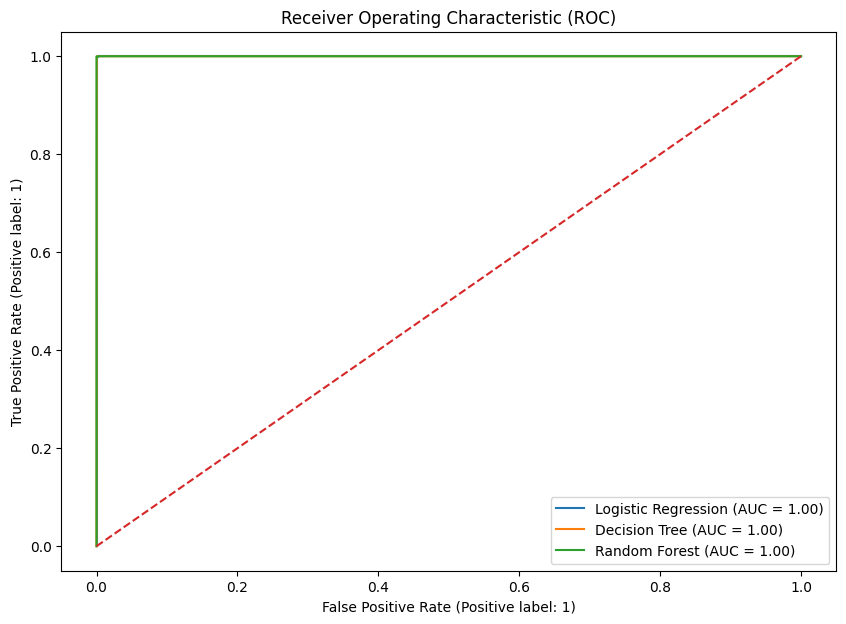

In [21]:
classifier_comparison(xtrain=xtrain_prepro, ytrain=ytrain_prepro, xtest=xtest_prepro, ytest=ytest)

## GridSearchCV

In [ ]:
def grid_search(
    x: pd.DataFrame,
    y: pd.DataFrame,
    xtest: pd.DataFrame = None,
    ytest: pd.DataFrame = None,
    clf = RandomForestClassifier(random_state=420),
    param_grid: dict = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
        },
    predict: bool = False
    ):

    # run name
    clf_name = str(clf).split("(")[0]
    run_name = f"Grid Search - {clf_name}"

    # Search for preprocessing run
    run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{run_name}'")
    # get run id
    run_id = run.iloc[0].run_id if not run.empty else None

    # if no predictions needed
    # fit grid search to data and log model
    if predict is False:
        # delete the last run if it exists
        if run_id is not None:
            mlflow.delete_run(run_id)
            
        # start run
        with mlflow.start_run(run_name=run_name) as run:
            # initialize grid search
            grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
            # fit grid search
            grid.fit(x, y)
            # # log model
            mlflow.sklearn.log_model(grid, f'GridSearch_{clf_name}')
            # # log best parameters
            mlflow.log_param('best_params', grid.best_params_)
            # print message
            print('GridSearchCV: fit')
            # end run
            mlflow.end_run()

    elif predict:
        # initialize grid search
        grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
        # fit grid search
        grid.fit(x, y)
        # predict
        ypred = grid.predict(xtest)
        # print classification report
        print(classification_report(ytest, ypred))

In [ ]:
# logistic regression grid_params
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }

grid_search(
    x=xtrain_prepro,
    y=ytrain_prepro,
    xtest=xtest_prepro,
    ytest=ytest,
    clf=LogisticRegression(random_state=420),
    param_grid=grid_params,
    predict=True
    )

In [ ]:
# decision tree grid_params
grid_params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
    }

grid_search(
    x=xtrain_prepro,
    y=ytrain_prepro,
    xtest=xtest_prepro,
    ytest=ytest,
    clf=DecisionTreeClassifier(random_state=420),
    param_grid=grid_params,
    predict=True
    )

In [ ]:
grid_search(
    x=xtrain_prepro,
    y=ytrain_prepro,
    xtest=xtest_prepro,
    ytest=ytest,
    clf=RandomForestClassifier(random_state=420),
    predict=True
    )

## Train Model with GridSearchCV-Parameters and all Training Data

In [22]:
def training(
        x: pd.DataFrame,
        y: pd.DataFrame,
        clf = RandomForestClassifier(random_state=420),
        # reset: bool = False
        ):
    
    # run name
    clf_name = str(clf).split("(")[0]
    run_name = f"Trained Model - {clf_name}"

    # check if grid search run exists
    model_grid_search = f"Grid Search - {clf_name}"

    # Search for grid search run
    run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{model_grid_search}'")
    # get run id
    run_id = run.iloc[0].run_id if not run.empty else None
    
    # if grid search run does not exist
    if run.empty:
        print(f'No grid search run found for {clf_name}')
        print('Model logged with default parameters')
        # initialize default model
        model = clf

    # if grid search run exists
    else:
        print(f'Grid search run found for {clf_name}')
        print('Model logged with optimal parameters')
        # load grid search model
        model = mlflow.sklearn.load_model(f'runs:/{run_id}/GridSearch_{clf_name}')

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # fit model
        model.fit(x, y)
        # log model
        mlflow.sklearn.log_model(model, 'model')
        # end run
        mlflow.end_run()

In [23]:
# combine train and test data
x, y = preprocessing(x=pd.concat([xtrain, xtest], axis=0), y=pd.concat([ytrain, ytest], axis=0), reset=True)

2023/06/11 17:52:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Last run deleted
Preprocessing Pipeline: fit and transform


In [24]:
# logistic regression grid_params
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
# grid search on full train dataset
grid_search(x=x, y=y, clf=LogisticRegression(random_state=420), param_grid=grid_params)
# train model on full train dataset
training(x=x, y=y, clf=LogisticRegression(random_state=420))

NameError: name 'grid_search' is not defined

In [ ]:
# decision tree grid_params
grid_params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
    }
# grid search on full train dataset
grid_search(x=x, y=y, clf=DecisionTreeClassifier(random_state=420), param_grid=grid_params)
# train model on full train dataset
training(x=x, y=y, clf=DecisionTreeClassifier(random_state=420))

In [ ]:
# random forest grid_params
grid_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
    }
# grid search on full train dataset
grid_search(x=x, y=y, clf=RandomForestClassifier(random_state=420), param_grid=grid_params)
# train model on full train dataset
training(x=x, y=y, clf=RandomForestClassifier(random_state=420))

## Prediction

In [25]:
def predict_new_data(x, y, clf = RandomForestClassifier(random_state=420)):

    # get dataframe name
    dataframe_name = [i for i in globals() if globals()[i] is x][0]

    # run name
    clf_name = str(clf).split("(")[0]
    run_name = f"{clf_name} Prediction - {dataframe_name}"

    # check if classifier already got trained
    trained_model_search = f"Trained Model - {clf_name}"

    # search run
    run = mlflow.search_runs(experiment_ids=experiment_id, filter_string=f"tags.mlflow.runName = '{trained_model_search}'")
    
    # if no trained model found
    if run.empty:
        print(f'No trained model found for {clf_name}')
    # if trained model found
    else:
        print(f'Trained model found for {clf_name}\n\n')
        # get run id
        run_id = run.iloc[0].run_id if not run.empty else None
        # load model (optimal)
        model = mlflow.sklearn.load_model(f'runs:/{run_id}/model')

    # predict on new data
    ypred_proba = model.predict_proba(x)
    ypred = np.argmax(ypred_proba, axis=1)

    # start run
    with mlflow.start_run(run_name=run_name) as run:
        # log model accuracy
        mlflow.log_metric(f'{dataframe_name}_accuracy', accuracy_score(y, ypred))
        # log model precision
        mlflow.log_metric(f'{dataframe_name}_precision', precision_score(y, ypred))
        # log model recall
        mlflow.log_metric(f'{dataframe_name}_recall', recall_score(y, ypred))
        # log model f1-score
        mlflow.log_metric(f'{dataframe_name}_f1_score', f1_score(y, ypred))
        # log parameters
        # mlflow.log_param(f'{dataframe_name}_params', model.get_params())
        # log model
        mlflow.sklearn.log_model(model, f'{dataframe_name}_model')
        # print classification report
        print(f'Classification Report:\n\n{classification_report(y, ypred)}\n\n')
        # end run
        mlflow.end_run()

    return ypred_proba, ypred

# Great Expectations

In [26]:
def great_expectations(check_dataframe, initial_dataframe=df1):

    initial_df = gx.dataset.PandasDataset(initial_dataframe)
    check_df = gx.dataset.PandasDataset(check_dataframe)
    
    # get column names from initial dataframe
    gx_columns = initial_df.get_table_columns()
    # get dtypes from initial dataframe
    gx_dtypes = initial_df.dtypes.apply(lambda x: str(x)).to_dict()

    # check if column are the same in all dataframes
    column_check = check_df.expect_table_columns_to_match_ordered_list(column_list=gx_columns)
    if column_check['success']:
        print('Columns Check: ', colored('OK', 'green'))
    else:
        print('Columns Check: ', colored('Failed', 'red'))

    # check if dtypes are the same in all dataframes
    check_set = set()
    for col, data_type in gx_dtypes.items():
        datatype_check = check_df.expect_column_values_to_be_of_type(column=col, type_=data_type)
        check_set.add(datatype_check['success'])
    if all(check_set) == True:
        print('Datatype Check: ', colored('OK', 'green'))
    else:
        print('Datatype Check: ', colored('Failed', 'red'))

    # check if dataframe has missing values
    check_set = set()
    for col in gx_columns:
        missing_values_check = check_df.expect_column_values_to_not_be_null(column=col)
        check_set.add(missing_values_check['success'])
    if all(check_set) == True:
        print('Missing Values Check: ', colored('OK', 'green'))
    else:
        print('Missing Values Check: ', colored('Failed', 'red'))

    # check if dataframe has duplicates
    duplicates_check = check_df.expect_table_row_count_to_be_between(min_value=check_df.shape[0], max_value=check_df.shape[0])
    if duplicates_check['success']:
        print('Duplicates Check: ', colored('OK', 'green'))
    else:
        print('Duplicates Check: ', colored('Failed', 'red'))

    # check if dataframe distribution is the same as in initial dataframe
    check_set = set()
    for col in gx_columns:
        distribution_check = check_df.expect_column_kl_divergence_to_be_less_than(column=col, partition_object={'values': initial_df[col].value_counts().index.tolist(), 'weights': initial_df[col].value_counts(normalize=True).tolist()}, threshold=0.6)
        check_set.add(distribution_check['success'])
    if all(check_set) == True:
        print('Distribution Check: ', colored('OK', 'green'))
    else:
        print('Distribution Check: ', colored('Failed', 'red'))

    # check if dataframe has outliers
    check_set = set()
    for col in gx_columns:
        outliers_check = check_df.expect_column_values_to_be_between(column=col, min_value=initial_df[col].min(), max_value=initial_df[col].max())
        check_set.add(outliers_check['success'])
    if all(check_set) == True:
        print('Outlier Check: ', colored('OK', 'green'))
    else:
        print('Outlier Check: ', colored('Failed', 'red'))

# Dataset 2

In [27]:
great_expectations(check_dataframe=df2, initial_dataframe=df1)

Columns Check:  OK
Datatype Check:  OK
Missing Values Check:  OK
Duplicates Check:  OK
Distribution Check:  Failed
Outlier Check:  Failed


In [28]:
df2_prepro, df2_y = preprocessing(df2.drop(columns=['Fire Alarm'])), df2['Fire Alarm']

Preprocessing Pipeline: transform


In [29]:
df2_y_proba_lr, df2_y_pred_lr = predict_new_data(df2_prepro, df2_y, clf=LogisticRegression(random_state=420))

Trained model found for LogisticRegression


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3178
           1       0.85      1.00      0.92     17698

    accuracy                           0.85     20876
   macro avg       0.42      0.50      0.46     20876
weighted avg       0.72      0.85      0.78     20876





In [30]:
df2_y_proba_dt, df2_y_pred_dt = predict_new_data(df2_prepro, df2_y, clf=DecisionTreeClassifier(random_state=420))

Trained model found for DecisionTreeClassifier


Classification Report:

              precision    recall  f1-score   support

           0       0.37      1.00      0.54      3178
           1       1.00      0.70      0.82     17698

    accuracy                           0.74     20876
   macro avg       0.69      0.85      0.68     20876
weighted avg       0.90      0.74      0.78     20876





In [31]:
df2_y_proba_rf, df2_y_pred_rf = predict_new_data(df2_prepro, df2_y, clf=RandomForestClassifier(random_state=420))

Trained model found for RandomForestClassifier


Classification Report:

              precision    recall  f1-score   support

           0       0.64      1.00      0.78      3178
           1       1.00      0.90      0.95     17698

    accuracy                           0.91     20876
   macro avg       0.82      0.95      0.86     20876
weighted avg       0.94      0.91      0.92     20876





# Dataset 3

In [32]:
great_expectations(check_dataframe=df3, initial_dataframe=df1)

Columns Check:  OK
Datatype Check:  OK
Missing Values Check:  OK
Duplicates Check:  OK
Distribution Check:  Failed
Outlier Check:  Failed


In [33]:
df3_prepro, df3_y = preprocessing(df3.drop(columns=['Fire Alarm'])), df3['Fire Alarm']

Preprocessing Pipeline: transform


In [34]:
df3_y_proba_lr, df3_y_pred_lr = predict_new_data(df3_prepro, df3_y, clf=LogisticRegression(random_state=420))

Trained model found for LogisticRegression


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5775
           1       1.00      1.00      1.00     15103

    accuracy                           1.00     20878
   macro avg       1.00      1.00      1.00     20878
weighted avg       1.00      1.00      1.00     20878





In [35]:
df3_y_proba_dt, df3_y_pred_dt = predict_new_data(df3_prepro, df3_y, clf=DecisionTreeClassifier(random_state=420))

Trained model found for DecisionTreeClassifier


Classification Report:

              precision    recall  f1-score   support

           0       0.16      0.49      0.24      5775
           1       0.05      0.01      0.02     15103

    accuracy                           0.14     20878
   macro avg       0.10      0.25      0.13     20878
weighted avg       0.08      0.14      0.08     20878





In [36]:
df3_y_proba_rf, df3_y_pred_rf = predict_new_data(df3_prepro, df3_y, clf=RandomForestClassifier(random_state=420))

Trained model found for RandomForestClassifier


Classification Report:

              precision    recall  f1-score   support

           0       0.34      1.00      0.50      5775
           1       1.00      0.24      0.39     15103

    accuracy                           0.45     20878
   macro avg       0.67      0.62      0.45     20878
weighted avg       0.82      0.45      0.42     20878





# Nanny ML Test

**ToDo:**
- Try out different bins/chunks

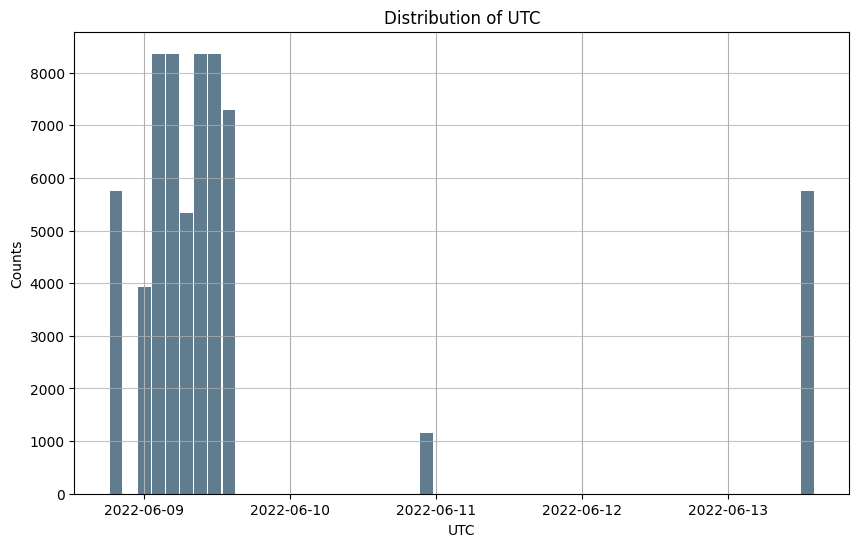

In [37]:
import matplotlib.pyplot as plt

# Convert UTC to datetime if it's in timestamp format
dataframe['UTC'] = pd.to_datetime(dataframe['UTC'], unit='s')
# Create a new figure and set the size of the figure
plt.figure(figsize=(10, 6))
# Plot the distribution of 'UTC' 
dataframe['UTC'].hist(bins=50, rwidth=0.9, color='#607c8e')
# Set grid
plt.grid(axis='y', alpha=0.75)
# Set title and labels
plt.title('Distribution of UTC')
plt.xlabel('UTC')
plt.ylabel('Counts')
# Show the plot
plt.show()

In [38]:
df1_prepro, df1_y = preprocessing(df1.drop(columns=['Fire Alarm'])), df1['Fire Alarm']
df1_y_proba_rf, df1_y_pred_rf = predict_new_data(df1_prepro, df1_y, clf=RandomForestClassifier(random_state=420))

Preprocessing Pipeline: transform
Trained model found for RandomForestClassifier


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8920
           1       1.00      1.00      1.00     11956

    accuracy                           1.00     20876
   macro avg       1.00      1.00      1.00     20876
weighted avg       1.00      1.00      1.00     20876





In [39]:
# set up reference dataframe
# combine x and y
reference_data = pd.DataFrame(df1_prepro, columns=xtrain.columns)
reference_data['y_true'] = df1_y.values
# change UTC to timestamp
# reference_data['UTC'] = pd.to_datetime(reference_data['UTC'])
# drop CNT column
reference_data.drop(columns=['CNT'], inplace=True)
reference_data['y_pred'] = df1_y_pred_rf
reference_data['y_pred_proba'] = df1_y_proba_rf[:,1]

In [40]:
# set up new dataframe
df2_nanny = pd.DataFrame(df2_prepro, columns=xtrain.columns)
# set fire alarm column in df2_nanny to y
df2_nanny['y_true'] = df2_y.values
# change UTC to timestamp
# df2_nanny['UTC'] = pd.to_datetime(df2_nanny['UTC'])
# drop CNT column
df2_nanny.drop(columns=['CNT'], inplace=True)
df2_nanny['y_pred'] = df2_y_pred_rf
df2_nanny['y_pred_proba'] = df2_y_proba_rf[:,1]

In [41]:
# set up new dataframe
df3_nanny = pd.DataFrame(df3_prepro, columns=xtrain.columns)
df3_nanny['y_true'] = df3_y.values
# change UTC to timestamp
# df3_nanny['UTC'] = pd.to_datetime(df3_nanny['UTC'])
# drop CNT column
df3_nanny.drop(columns=['CNT'], inplace=True)
df3_nanny['y_pred'] = df3_y_pred_rf
df3_nanny['y_pred_proba'] = df3_y_proba_rf[:,1]

### Estimating performance

In [42]:

def estimate_performance(reference_df, analysis_df, metric='f1', lower_threshold=0.7, upper_threshold=1):
    constant_threshold = nml.thresholds.ConstantThreshold(lower=lower_threshold, upper=upper_threshold)
    
    estimator = nml.CBPE(
        y_pred_proba='y_pred_proba',
        y_pred='y_pred',
        y_true='y_true',
        #timestamp_column_name='timestamp',
        metrics=[metric],
        #chunk_size=5000,
        chunker = SizeBasedChunker(chunk_size=1000 , incomplete='append'),
        problem_type='classification_binary',
        thresholds={
            metric: constant_threshold
        }
    )
    
    estimator.fit(reference_df)
    results = estimator.estimate(analysis_df)
    columns = [('chunk', 'key'), ('chunk', 'period'), (metric, 'value'), (metric, 'upper_threshold'), (metric, 'lower_threshold'), (metric, 'alert')]
    
    # display the dataframe
    # display(results.to_df()[columns])
    
    # plot the results
    metric_fig = results.plot()
    metric_fig.show()


In [43]:
# # estimate performance of the first analysis dataset with f1 score
# estimate_performance(reference_data, df2_nanny, metric='f1', lower_threshold=0.8)
# # estimate performance of the second analysis dataset with recall
# estimate_performance(reference_data, df3_nanny, metric='recall')

### Monitoring Realized Performance - Calculating Standard Performance Metrics (not working)

In [44]:
def monitor_performance(reference_df, analysis_df, metric='recall', lower_threshold=0.7, upper_threshold=1):
    # create thresholds for the metric
    constant_threshold = nml.thresholds.ConstantThreshold(lower=lower_threshold, upper=upper_threshold)

    # create a dictionary with the threshold object for each metric
    thresholds = {metric: constant_threshold}
    
    calc = nml.PerformanceCalculator(
        y_pred_proba='y_pred_proba',
        y_pred='y_pred',
        y_true='y_true',
        # timestamp_column_name='UTC',
        problem_type='classification_binary',
        metrics=[metric],
        # chunk_size=1000,
        chunker = nml.SizeBasedChunker(chunk_size=1000 , incomplete='append'),    
        thresholds=thresholds
        )
    # fit the reference data and calculate results
    calc.fit(reference_df)
    results = calc.calculate(analysis_df)
    # display the dataframe
    # display(results.filter(period='analysis').to_df())
    # plot the results
    figure = results.plot()
    figure.show()


In [45]:
# monitor standard performance metrics on first analysis dataset
# monitor_performance(reference_data, df2_nanny, metric='recall')

### Monitoring Realized Performance - Calculating Confusion Matrix Elements

In [46]:
def monitor_performance_conf_matrix(reference_df, analysis_df):
    calc = nml.PerformanceCalculator(
        y_pred_proba='y_pred_proba',
        y_pred='y_pred',
        y_true='y_true',
        # timestamp_column_name='timestamp',
        problem_type='classification_binary',
        metrics=['confusion_matrix'],
        normalize_confusion_matrix='all',
        #chunk_size=1000,
        chunker = SizeBasedChunker(chunk_size=1000 , incomplete='append'),
        )
    # fit the reference data and calculate the results
    calc.fit(reference_df)
    results = calc.calculate(analysis_df)
    # display the results
    # display(results.filter(period='analysis').to_df())
    # display(results.filter(period='reference').to_df())
    figure = results.plot()
    figure.show()

In [47]:
# plot realized performance (confusion matrix elements) for first analysis period
# monitor_performance_conf_matrix(reference_data, df2_nanny)

### Comparing Estimated and Realized Performance  (also not fully working)

In [48]:
def compare_estimated_realized(reference_df, analysis_df, metric='recall'):
    # Estimate performance without targets
    estimator = nml.CBPE(
        y_pred_proba='y_pred_proba',
        y_pred='y_pred',
        y_true='y_true',
        # timestamp_column_name='UTC', # not possible
        metrics=[metric], #'roc_auc' is not possible
        #chunk_size=1000,
        chunker = SizeBasedChunker(chunk_size=1000 , incomplete='append'),
        problem_type='classification_binary',
    )
    # fit the estimator and estimate the results
    estimator.fit(reference_df)
    results = estimator.estimate(analysis_df)
    # display the results
    # display(results.filter(period='analysis').to_df())

    # Calculate realized performance using targets
    calc = nml.PerformanceCalculator(
        y_pred_proba='y_pred_proba',
        y_pred='y_pred',
        y_true='y_true',
        # timestamp_column_name='UTC',
        problem_type='classification_binary',
        metrics=[metric],
        # chunk_size=1000,
        chunker = SizeBasedChunker(chunk_size=1000 , incomplete='append')    
        )
    # fit the reference data and calculate results
    calc.fit(reference_df)
    realized_results = calc.calculate(analysis_df)
    # display(realized_results.filter(period='analysis').to_df())

    # Show comparison plot
    results.filter(period='analysis').compare(realized_results).plot().show()

In [49]:
# # compare estimated and realized f1 for first analysis period
# compare_estimated_realized(reference_data, df2_nanny, metric='f1')
# # compare estimated and realized accuracy for first analysis period
# compare_estimated_realized(reference_data, df2_nanny, metric='accuracy')

### Univariate Drift Detection

In [50]:
def plot_univariate_drift(reference_df, analysis_df):
    # define column names
    column_names = reference_data.columns.tolist()
    column_names.remove('y_true')
    column_names.remove('UTC')
    # define drift calculator
    calc = nml.UnivariateDriftCalculator(
        column_names=column_names,
        treat_as_categorical=['y_pred'],
        # timestamp_column_name='UTC',
        continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
        categorical_methods=['chi2', 'jensen_shannon'],
        chunker = SizeBasedChunker(chunk_size=1000 , incomplete='append'),
        )
    # fit reference data and calculate drift
    calc.fit(reference_df)
    results = calc.calculate(analysis_df)
    # display(results.filter(period='analysis', column_names=['debt_to_income_ratio']).to_df())
    # plot drift and distribution
    figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
    figure.show()
    figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='drift')
    figure.show()
    figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
    figure.show()
    figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='distribution')
    figure.show()

In [51]:
# plor univariate drift for first analysis dataset
# plot_univariate_drift(reference_data, df2_nanny)

### Ranking univariate Drift results

In [62]:
# define alert_count_ranking
def alert_count_ranking(reference_df, analysis_df, method='jensen_shannon', only_drifting=False):
    # define column names
    column_names = reference_df.columns.tolist()
    column_names.remove('y_true')
    column_names.remove('UTC')

    univ_calc = nml.UnivariateDriftCalculator(
        column_names=column_names,
        treat_as_categorical=['y_pred'],
        continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
        categorical_methods=['chi2', 'jensen_shannon'],
        chunker = nml.SizeBasedChunker(chunk_size=1000 , incomplete='append')
    )
    univ_calc.fit(reference_df)
    univariate_results = univ_calc.calculate(analysis_df)

    alert_count_ranker = nml.AlertCountRanker()
    alert_count_ranked_features = alert_count_ranker.rank(
        univariate_results.filter(methods=[method]),
        only_drifting=only_drifting)
    return alert_count_ranked_features

In [63]:
alert_count_ranking(reference_data, df2_nanny, method='jensen_shannon')

,number_of_alerts,column_name,rank
0,20,y_pred_proba,1
1,20,eCO2[ppm],2
2,20,Temperature[C],3
3,20,Raw H2,4
4,20,Raw Ethanol,5
5,20,NC2.5,6
6,20,Humidity[%],7
7,19,y_pred,8
8,0,TVOC[ppb],9
9,0,Pressure[hPa],10


In [56]:
def correlation_ranking(reference_df, analysis_df, method='jensen_shannon', metric='recall', only_drifting=False):
    # define column names
    column_names = reference_df.columns.tolist()
    column_names.remove('y_true')
    column_names.remove('UTC')

    univ_calc = nml.UnivariateDriftCalculator(
        column_names=column_names,
        treat_as_categorical=['y_pred'],
        continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
        categorical_methods=['chi2', 'jensen_shannon'],
        chunker = nml.SizeBasedChunker(chunk_size=1000 , incomplete='append')
    )
    univ_calc.fit(reference_df)
    univariate_results = univ_calc.calculate(analysis_df)

    perf_calc = nml.CBPE(
        y_pred_proba='y_pred_proba',
        y_pred='y_pred',
        y_true='y_true',
        metrics=[metric],
        chunker = nml.SizeBasedChunker(chunk_size=1000 , incomplete='append'),
        problem_type='classification_binary',
    )
    perf_calc.fit(reference_df)
    perf_results = perf_calc.estimate(analysis_df)

    ranker = nml.CorrelationRanker()
    ranker.fit(perf_results.filter(period='analysis', metrics=[metric]))
    correlation_ranked_features = ranker.rank(
        univariate_results.filter(methods=[method]),
        perf_results.filter(metrics=[metric]),
        only_drifting=only_drifting)
    return correlation_ranked_features


In [59]:
correlation_ranking(reference_data, df2_nanny, method='jensen_shannon')

,column_name,pearsonr_correlation,pearsonr_pvalue,has_drifted,rank
0,y_pred,0.669386,0.000002,True,1
1,Temperature[C],0.431029,0.005492,True,2
2,Humidity[%],0.367993,0.019479,True,3
3,TVOC[ppb],0.360745,0.022207,True,4
4,Pressure[hPa],0.356186,0.024081,True,5
5,PM2.5,0.349932,0.026864,True,6
6,PM1.0,0.349166,0.027222,True,7
7,NC0.5,0.346329,0.028584,True,8
8,NC1.0,0.266665,0.096246,True,9
9,y_pred_proba,0.033686,0.836517,True,10


### Multivariate Drift Detection

In [75]:

def plot_multivariate_drift(reference_df, analysis_df, lower_threshold=0.1, upper_threshold=2):
    constant_threshold = nml.thresholds.ConstantThreshold(lower=lower_threshold, upper=upper_threshold)
    # define feature column names
    feature_column_names = reference_data.columns.tolist()
    feature_column_names.remove('y_true')
    feature_column_names.remove('UTC')
    feature_column_names.remove('y_pred_proba')
    feature_column_names.remove('y_pred')
    #define drift calculator
    calc = nml.DataReconstructionDriftCalculator(
        column_names=feature_column_names,
        # timestamp_column_name='timestamp',
        # chunk_size=1000,
        chunker = nml.SizeBasedChunker(chunk_size=1000 , incomplete='append'),
        #thresholds = constant_threshold,
        imputer_categorical=SimpleImputer(strategy='constant', fill_value='missing'),
        imputer_continuous=SimpleImputer(strategy='median'),
    )
    calc.fit(reference_df)
    results = calc.calculate(analysis_df)
    # display results
    # display(results.filter(period='analysis').to_df())
    # display(results.filter(period='reference').to_df())
    figure = results.plot()
    figure.show()

In [76]:
plot_multivariate_drift(reference_data, df2_nanny)

# Retrain

In [ ]:
# # combine xtrain_prepro, xtest_prepro and df2_prepro
# x_retrain = preprocessing(pd.concat([xtrain, xtest, df2.drop(columns=['Fire Alarm'])], axis=0), reset=True)
# # combine ytrain_prepro, ytest and df2_y
# y_retrain = np.concatenate((ytrain_prepro, ytest, df2['Fire Alarm']), axis=0)

In [ ]:
# # logistic regression grid_params
# grid_params = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#     }
# # grid search on retrain dataset
# grid_search(x=x_retrain, y=y_retrain, clf=LogisticRegression(random_state=420), param_grid=grid_params)
# # train model on retrain dataset
# training(x=x_retrain, y=y_retrain, clf=LogisticRegression(random_state=420))

In [ ]:
# # decision tree grid_params
# grid_params = {
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
#     }
# # grid search on retrain dataset
# grid_search(x=x_retrain, y=y_retrain, clf=DecisionTreeClassifier(random_state=420), param_grid=grid_params)
# # train model on retrain dataset
# training(x=x_retrain, y=y_retrain, clf=DecisionTreeClassifier(random_state=420))

In [ ]:
# # random forest grid_params
# grid_params = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
#     }
# # grid search on retrain dataset
# grid_search(x=x_retrain, y=y_retrain, clf=RandomForestClassifier(random_state=420), param_grid=grid_params)
# # train model on retrain dataset
# training(x=x_retrain, y=y_retrain, clf=RandomForestClassifier(random_state=420))

In [ ]:
# predict_new_data(df3_prepro, df3_y, LogisticRegression(random_state=420))

In [ ]:
# predict_new_data(df3_prepro, df3_y, DecisionTreeClassifier(random_state=420))

In [ ]:
# predict_new_data(df3_prepro, df3_y, DecisionTreeClassifier(random_state=420))